In [ ]:
import re
import numpy as np 
import pandas as pd 
from spellchecker import SpellChecker
import contractions
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
ps = WordNetLemmatizer()

nltk.download('wordnet')
nltk.download('stopwords')

In [31]:
# import cleaned data
data = pd.read_csv("scam_data.csv",sep=",")

C:\Users\Chew Jin Ni\AppData\Local\Temp\ipykernel_25504\1652064216.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_Class=pd.value_counts(data["label"], sort= True)


<Axes: xlabel='label'>

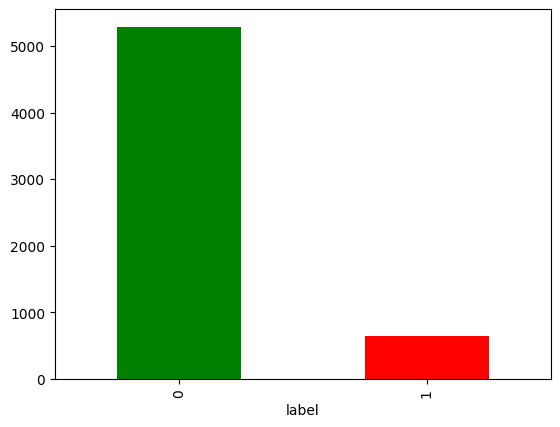

In [6]:
# visualize data
import seaborn as sns

data['label'].value_counts()
count_Class=pd.value_counts(data["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])

In [7]:
def clean_data(data) :
    contents = []
    for i in range(0, len(data)) :
        sentence = re.sub('[^a-zA-Z]', ' ', data['content'][i])
        sentence = sentence.lower()
        sentence = sentence.split()
        sentence = [ps.lemmatize(word) for word in sentence if word not in stopwords.words('english')]
        sentence = ' '.join(sentence)
        rp_sentence = contractions.fix(sentence)
        contents.append(rp_sentence)
    return contents

In [32]:
# Characters to remove
characters_to_remove = ['p', 'sir', 'stop', 'are', 'c', 'please', 'txt', 'lt', 'gt', 'lor', 'r', 'da', 'oh', 'k', 'pls', 'let', 'i']
data = data.dropna(subset=['no_pron'])
# Define a function to remove characters
def remove_characters(text):
    # Use regular expression with word boundaries to match only standalone words
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in characters_to_remove) + r')\b'
    # Replace matched characters with an empty string
    return re.sub(pattern, '', text)

# Apply the function to remove characters from the 'no_pron' column
data['no_pron'] = data['no_pron'].apply(remove_characters)


In [9]:
def clean_sentence(data) :
    review = re.sub('[^a-zA-Z]', ' ', data)
    review = review.lower()
    review = review.split()
    review = [ps.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    return review

[('call', 302), ('free', 164), ('mobile', 119), ('text', 116), ('number', 94), ('claim', 88), ('prize', 81), ('message', 81), ('hello', 77), ('reply', 74), ('min', 66), ('get', 64), ('tone', 63), ('service', 61), ('www', 61), ('new', 58), ('customer', 58), ('bank', 57), ('cash', 57), ('account', 57), ('want', 56), ('send', 54), ('week', 54), ('win', 52), ('nokia', 50), ('phone', 49), ('uk', 49), ('urgent', 46), ('card', 45), ('tell', 45), ('contact', 43), ('box', 42), ('com', 39), ('guaranteed', 36), ('per', 36), ('draw', 32), ('co', 31), ('awarded', 31), ('day', 31), ('w', 31), ('today', 30), ('receive', 30), ('latest', 29), ('rate', 29), ('video', 29), ('chat', 29), ('ppm', 29), ('award', 28), ('voucher', 28), ('line', 27), ('pobox', 27), ('offer', 26), ('camera', 25), ('po', 25), ('landline', 25), ('show', 24), ('live', 24), ('orange', 24), ('selected', 23), ('go', 23), ('holiday', 23), ('ringtone', 23), ('every', 23), ('st', 23), ('care', 22), ('kyc', 22), ('credit', 22), ('pm', 22

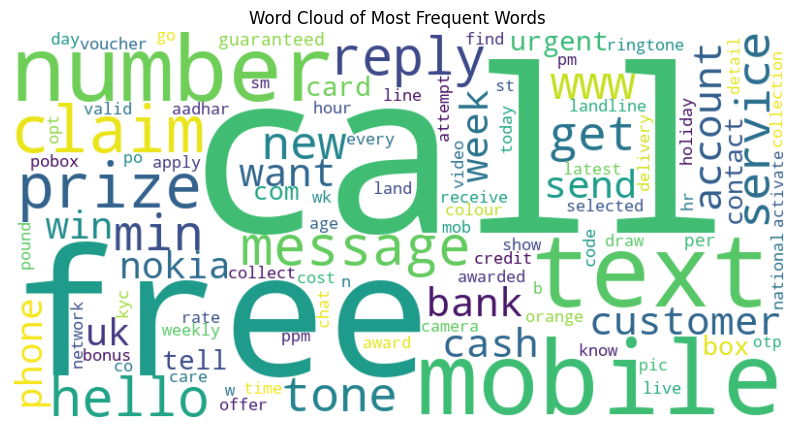

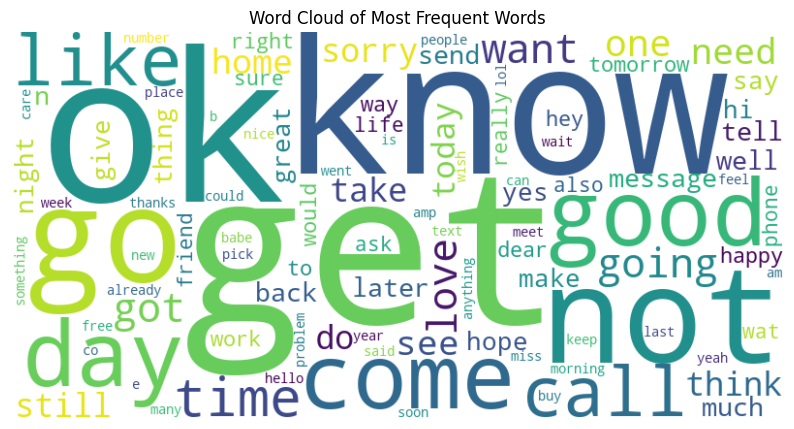

In [33]:
# get most frequent appear words in scam and non-scam call
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
def most_frequent_words(text, top_n=100):
    # Filter out non-string values and convert to lowercase
    valid_texts = [str(sentence).lower() for sentence in text if isinstance(sentence, str)]
    
    # Tokenize the text into words
    tokenized_data = [word_tokenize(sentence) for sentence in valid_texts]
    
    # Flatten the list of tokenized words
    words = [word for sentence in tokenized_data for word in sentence]
    
    # Calculate word frequencies
    freq_dist = FreqDist(words)

    # Get the top N words with highest frequencies
    top_words = freq_dist.most_common(top_n)

    return top_words


scam_words = most_frequent_words(data[data['label'] == 1]['no_pron'])
print(scam_words)
non_scam_words = most_frequent_words(data[data['label'] == 0]['no_pron'])
print(non_scam_words)


# visualize most frequent appear words in scam and non-scam call
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a word cloud
def generate_word_cloud(top_words):
    # Create a dictionary from the list of tuples (word, frequency)
    word_freq_dict = dict(top_words)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Most Frequent Words')
    plt.show()

generate_word_cloud(scam_words)
generate_word_cloud(non_scam_words)


In [45]:
# Logistic Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# Feature Extraction
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['no_pron'])
y = data['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Model Selection and Training
model = LogisticRegression()
model.fit(X_train_balanced, y_train_balanced)

# Evaluation
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cl_r = classification_report(y_test,y_ped)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Classification report id:",cl_r)

Confusion Matrix:
[[1023   15]
 [  19  125]]
Accuracy: 0.9712351945854484
Recall: 0.8680555555555556
Classification report id:               precision    recall  f1-score   support

           0       0.88      0.85      0.87      1038
           1       0.12      0.15      0.13       144

    accuracy                           0.77      1182
   macro avg       0.50      0.50      0.50      1182
weighted avg       0.79      0.77      0.78      1182



In [37]:
# Naive Bayes model
from sklearn.metrics import recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score
"""creating/training of model."""
X = vectorizer.fit_transform(data['no_pron'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
fraud_detect = MultinomialNB().fit(X_train_balanced, y_train_balanced)
y_ped = fraud_detect.predict(X_test)
cong_m = confusion_matrix(y_test, y_ped)
acc = accuracy_score(y_test, y_ped)
recall = recall_score(y_test,y_ped)
cl_r = classification_report(y_test,y_ped)
print("Confusion matrix:", cong_m)
print("Accuracy_score:", acc)
print("recall_score is:",recall)
print("Classification report id:",cl_r)

Confusion matrix: [[999  49]
 [ 11 123]]
Accuracy_score: 0.949238578680203
recall_score is: 0.917910447761194
Classification report id:               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1048
           1       0.72      0.92      0.80       134

    accuracy                           0.95      1182
   macro avg       0.85      0.94      0.89      1182
weighted avg       0.96      0.95      0.95      1182



In [40]:
import speech_recognition as sr
import pyttsx3
import pyaudio

# Initialize the recognizer
r = sr.Recognizer()

# Function to convert text to speech
def SpeakText(command):
     
    # Initialize the engine
    engine = pyttsx3.init()
    engine.say(command)
    engine.runAndWait()
     
     
# Loop infinitely for user to
# speak
 
while(True):   
     
    # Exception handling to handle
    # exceptions at the runtime
    try:
         
        # use the microphone as source for input.
        with sr.Microphone() as source2:
             
            # wait for a second to let the recognizer
            # adjust the energy threshold based on
            # the surrounding noise level
            r.adjust_for_ambient_noise(source2, duration= 1)
             
            #listens for the user's input
            audio2 = r.listen(source2)
             
            # Using google to recognize audio
            MyText = r.recognize_google(audio2)
            MyText = MyText.lower()
 
            print("Did you say ",MyText)
            if(MyText == 'stop'):
                break
                
            text = clean_sentence(MyText)
            new_data = vectorizer.transform([text]).toarray()
            # Logistic Regression Model
            predictions = model.predict(new_data)
            #Naive Bayes
            predictions2 = fraud_detect.predict(new_data)

            # print(predictions)
            if predictions == 0:
                print("Not Scam")
            elif predictions == 1:
                print("Scam")

            if predictions2 == 0:
                print("Not Scam")
            elif predictions2 == 1:
                print("Scam")
           
             
    except sr.RequestError as e:
       print("Could not request results; {0}".format(e))
         
    except sr.UnknownValueError:
       print("Could not understand")

Could not understand
Did you say  win a 20000
Scam
Scam
Did you say  actor payne the transaction fee
Not Scam
Not Scam
Did you say  hello do you want to go shopping later
Not Scam
Not Scam
Did you say  who is press 1 2 3 2 redeem your price
Not Scam
Not Scam
Could not understand
Did you say  please click 1232 from your price
Not Scam
Scam
Did you say  please click this link to get your price
Not Scam
Scam
Could not understand
Did you say  do you know do you know who i am
Not Scam
Not Scam
Could not understand
Did you say  show me 2000 ringgit
Not Scam
Scam
Did you say  new borrow me 2000 ringgit i'm very urgent
Scam
Scam
Could not understand
Could not understand
Could not understand
Could not understand
Did you say  stop stop
Not Scam
Not Scam
Did you say  stop
